In [1]:
using Revise

In [2]:
project_root = dirname(pwd()) # notebooks ディレクトリから2つ上の階層を想定
src_path = joinpath(project_root, "codes")
if !(src_path in LOAD_PATH)
    push!(LOAD_PATH, src_path)
end
println("LOAD_PATH: ", LOAD_PATH)

LOAD_PATH: ["@", "@v#.#", "@stdlib", "/workspaces/inulab_julia_devcontainer/codes"]


In [3]:
using Pkg
using DelimitedFiles, DataFrames, Plots, Statistics, LinearAlgebra
using Printf
using DecisionAnalysis # This will load all submodules via DecisionAnalysis.jl

Plots.default(fontfamily="IPAexGothic") # Or your preferred font


In [4]:
# --- 1. Data Loading ---
function load_data_new( dataset_folder="A/MMRW", criteria_num=6)
    # Construct paths more robustly if needed
    base_path = "/workspaces/inulab_julia_devcontainer/data/" # Or make this configurable
    
    # Utility Data - assuming we use the first matrix from the list
    utility_file_path = joinpath(base_path, "効用値行列/u1/N=6_M=5/u.csv")
    all_utility_dfs_or_matrices = DecisionAnalysis.read_utility_value(utility_file_path)

    utility_data_matrix = all_utility_dfs_or_matrices[5] # Taking the first one
    

    all_method_weights = DecisionAnalysis.read_method_weights(dataset_folder,1, criteria_num)
    # Assuming we use the first set of weights
    method_weights_single = all_method_weights[1] 
    
    return utility_data_matrix, method_weights_single
end

# --- Main Execution ---
utility_data, method_weights = load_data_new( "A/MMRW", 6) # Adjusted to new signature


hi
Vector{Matrix{Float64}}
Vector{Matrix{Float64}}


([0.141571 0.00592 … 0.044464 0.050446; 0.070374 0.232666 … 0.283417 0.033417; … ; 0.155548 0.022339 … 0.313263 0.182831; 0.279572 0.126007 … 0.049774 0.268005], (L = [0.150363, 0.150363, 0.073647, 0.075181, 0.050121, 0.037591], R = [0.338316, 0.338316, 0.196392, 0.207397, 0.165918, 0.216395], adjacent = 0.925469))

In [5]:
# --- 2. Optimal t-range calculation ---
# `find_optimal_trange` now expects L and R vectors directly.
t_L_opt, t_R_opt = DecisionAnalysis.find_optimal_trange(method_weights.L, method_weights.R)
optimal_t_range = (t_L_opt, t_R_opt) # t_L_opt should be smaller
println("Optimal t-range: [", optimal_t_range[1], ", ", optimal_t_range[2], "]")

Optimal t-range: [0.7844484660502471, 1.378893823796674]


In [6]:
println(typeof(utility_data))
println(typeof(method_weights))
println(typeof(optimal_t_range))

analysis_results = DecisionAnalysis.analyze_overall_rank_changes(utility_data, method_weights, optimal_t_range)

Matrix{Float64}
@NamedTuple{L::Vector{Float64}, R::Vector{Float64}, adjacent::Float64}
Tuple{Float64, Float64}


AnalysisResults([0.141571 0.00592 … 0.044464 0.050446; 0.070374 0.232666 … 0.283417 0.033417; … ; 0.155548 0.022339 … 0.313263 0.182831; 0.279572 0.126007 … 0.049774 0.268005], (L = [0.150363, 0.150363, 0.073647, 0.075181, 0.050121, 0.037591], R = [0.338316, 0.338316, 0.196392, 0.207397, 0.165918, 0.216395], adjacent = 0.925469), (0.7844484660502471, 1.378893823796674), RankChangeDataPoint[RankChangeDataPoint(0.7844484660502471, [5, 3, 4, 1, 2])], OverallRankingAtT[OverallRankingAtT(0.7844484660502471, [5, 3, 4, 1, 2], [0.0472861206160117, 0.05446890162388678, 0.06273765267289048, 0.06906481773418337, 0.07040779273381076]), OverallRankingAtT(0.7903929196277114, [5, 3, 4, 1, 2], [0.047644448997065936, 0.05488166023217238, 0.06321307085523568, 0.06958818239180586, 0.0709413342900907]), OverallRankingAtT(0.7963373732051756, [5, 3, 4, 1, 2], [0.04800277737812016, 0.05529441884045796, 0.06368848903758087, 0.07011154704942837, 0.07147487584637065]), OverallRankingAtT(0.8022818267826399, [5, 

In [8]:
# --- 3. Analyze Rank Changes ---
# The utility_data should be UtilityMatrix (Matrix{Float64})
# method_weights should be MethodWeights struct
analysis_results = DecisionAnalysis.analyze_overall_rank_changes(utility_data, method_weights, optimal_t_range)

# --- Displaying Results (example) ---
println("\nTrue Overall Rank Change Points and Rankings:")
for rcdp in analysis_results.true_overall_rank_change_points
    @printf "  t = %.6f: Ranking = %s\n" rcdp.t_value rcdp.ranking
end


True Overall Rank Change Points and Rankings:
  t = 0.784448: Ranking = [5, 3, 4, 1, 2]


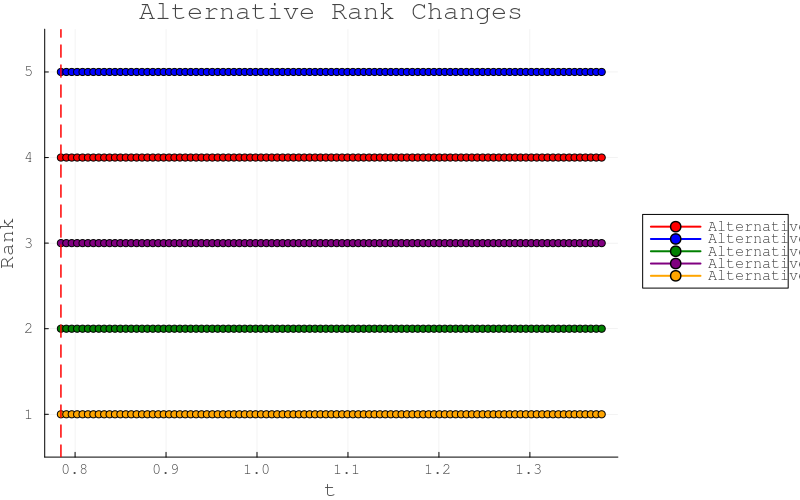


True Overall Rank Change Points and Rankings:
  t = 0.784448: Ranking = [5, 3, 4, 1, 2]


GKS: could not find font IPAexGothic.ttf


ArgumentError: ArgumentError: New columns must have the same length as old columns

In [ ]:


# --- 4. Plotting ---
function plot_rank_changes_new(results::DecisionAnalysis.AnalysisResults)
    evaluated_rankings = results.all_evaluated_rankings
    true_change_points = [rcdp.t_value for rcdp in results.true_overall_rank_change_points]

    if isempty(evaluated_rankings)
        println("Warning: plot_rank_changes - No evaluated ranking data available.")
        return plot(title="Alternative Rank Changes (No Data)", xlabel="t", ylabel="Rank", size=(800,500))
    end

    # Extract t points and number of alternatives from the first evaluated ranking
    # Ensure evaluated_rankings is sorted by t if not already guaranteed
    sort!(evaluated_rankings, by = x -> x.t)
    
    t_points_plot = [er.t for er in evaluated_rankings]
    n_alternatives = length(evaluated_rankings[1].ranking) # Assumes ranking vector has length n_alternatives

    if n_alternatives == 0
        println("Warning: plot_rank_changes - Number of alternatives is 0.")
        return plot(title="Alternative Rank Changes (No Alternatives)", xlabel="t", ylabel="Rank", size=(800,500))
    end

    p = plot(
        xlabel = "t",
        ylabel = "Rank",
        title = "Alternative Rank Changes",
        legend = :outerright,
        size = (800, 500),
        grid = true,
        yticks = 1:n_alternatives,
        ylims = (0.5, n_alternatives + 0.5)
    )
    
    colors = [:red, :blue, :green, :purple, :orange, :brown, :pink, :gray, :cyan, :magenta]

    for alt_id in 1:n_alternatives
        ranks_for_alt = Vector{Union{Nothing, Int}}(undef, length(t_points_plot))
        for (i, t_val) in enumerate(t_points_plot)
            # evaluated_rankings[i].ranking is [alt_at_rank1, alt_at_rank2, ...]
            # We need to find the rank of alt_id
            found_rank = findfirst(x -> x == alt_id, evaluated_rankings[i].ranking)
            ranks_for_alt[i] = found_rank
        end
        
        valid_indices = .!isnothing.(ranks_for_alt)
        if any(valid_indices)
            plot!(p, t_points_plot[valid_indices], ranks_for_alt[valid_indices],
                  label = "Alternative $alt_id",
                  marker = :circle,
                  color = colors[mod1(alt_id, length(colors))],
                  linewidth = 2
            )
        end
    end
    
    # Plot true rank change points
    plot_t_min = isempty(t_points_plot) ? -Inf : minimum(t_points_plot)
    plot_t_max = isempty(t_points_plot) ? Inf : maximum(t_points_plot)
    for cp in unique(true_change_points) # Use unique to avoid plotting multiple lines at same t
        if cp >= plot_t_min && cp <= plot_t_max
             vline!(p, [cp], linestyle=:dash, color=:red, label=nothing, linewidth=1.5)
        end
    end
    
    return p
end

rank_plot_new = plot_rank_changes_new(analysis_results)
display(rank_plot_new)
savefig(rank_plot_new, "rank_changes_plot_new.png")


# --- 5. Save Results to CSV ---
# The save_analysis_results_to_csv function is now part of DecisionAnalysis.DataIO
output_df = DecisionAnalysis.save_analysis_results_to_csv(analysis_results, "rank_change_details_new.csv")
display(output_df)